In [13]:
import pandas as pd
import numpy as np
import pyperclip as pc
import requests
import kaggle

# ___________________________________________________________________
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as ms
from sklearn import datasets, svm, metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ____________________________________________________________________
from scipy import stats
from statsmodels.stats import proportion
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [14]:
resp = pd.read_csv('resp.csv')
resp.columns = ['state', 'equipments']
resp_sum = resp['equipments'].sum()
resp = resp.set_index('state', drop = True)

In [129]:
str_today = (dt.date.today() - dt.timedelta(hours=18)).strftime('%Y-%m-%d')
str_cases = (dt.date.today() - dt.timedelta(days=13)).strftime('%Y-%m-%d')
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str_today + '.xlsx'
# file = requests.get(url)
world_data = pd.read_excel(url)
world_data.columns = ['date', 'day', 'month', 'year', 'cases', 'deaths', 'country', 'country_geoid', 'country_code', 'population']
print(str_cases + " - " + str_today)
# world_data.head(5)

2020-03-16 - 2020-03-29


In [130]:
pt_world_data = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data = pt_world_data.cumsum(axis = 1)
pt_world_data = pt_world_data[pt_world_data['2020-03-26'] > 1000].sort_values(by='2020-03-26', ascending = False)

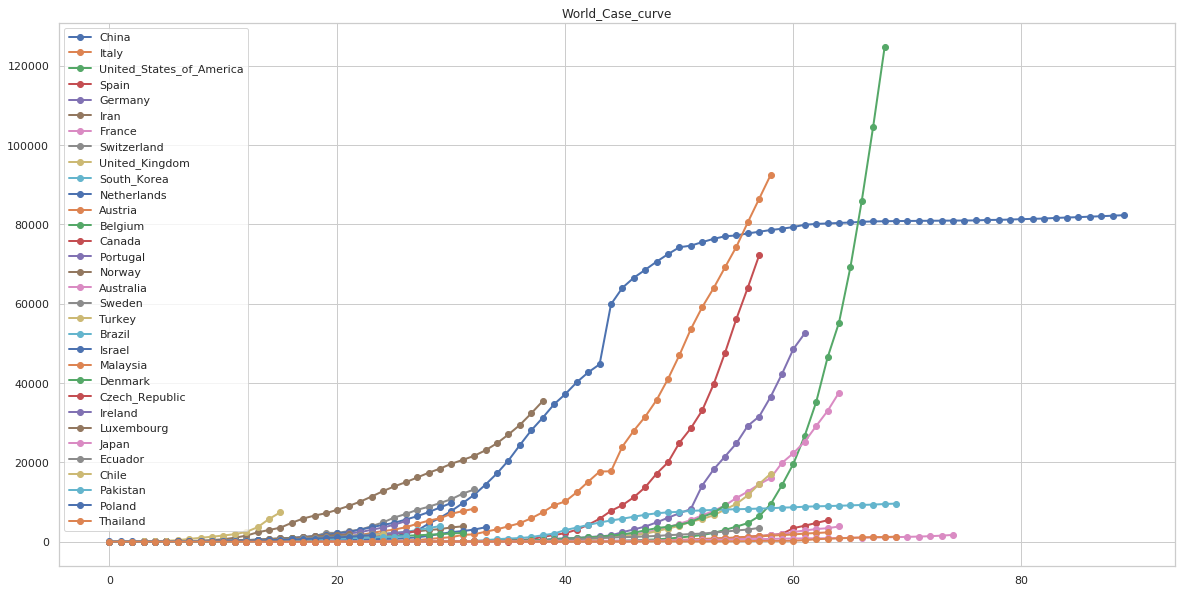

In [131]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)
title = 'World_Case_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

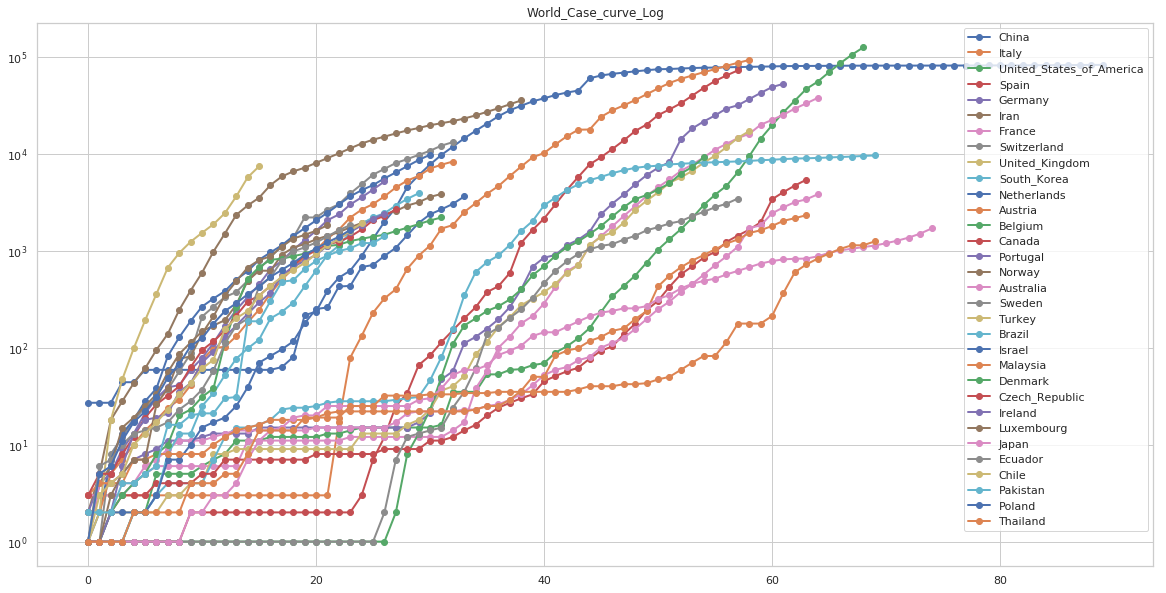

In [132]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
plt.yscale('log')
title = 'World_Case_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

s:  0.8446004309005914
s_star:  2.3270478123838654


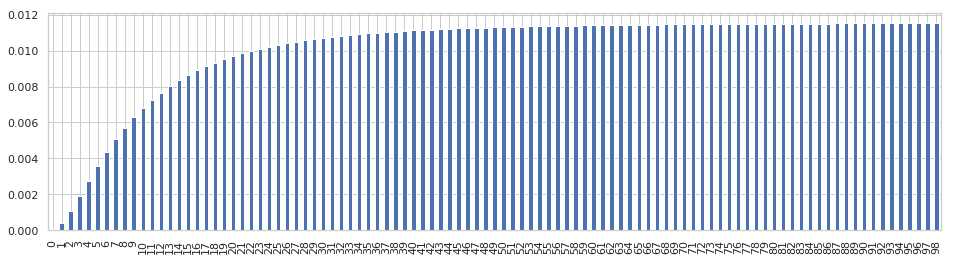

In [133]:
zmeanHDT = 13
zsdHDT = 12.7
zmedianHDT = 9.1
muHDT = np.log(zmedianHDT)
sigmaHDT = np.sqrt(2*(np.log(zmeanHDT/zmedianHDT)))
s = sigmaHDT
cCFRBaseline = 1.38
cCFREstimateRange = [1.23, 1.53]
cCFRIQRRange = [1.3, 1.4]

print('s: ',sigmaHDT)
print('s_star: ',np.exp(sigmaHDT))
# print('mu: ', muHDT)

# Hospitalisation to death distribution
def HDT(x):
    dist = stats.lognorm(s = sigmaHDT, scale = zmedianHDT)
    a = dist.cdf(x)
    return a
    

x = list(range(1,100))
p_curve = pd.Series([HDT(i) for i in x])
p_curve = p_curve / p_curve.sum()

plt.figure(figsize=(16,4))
p_curve.plot(kind='bar')


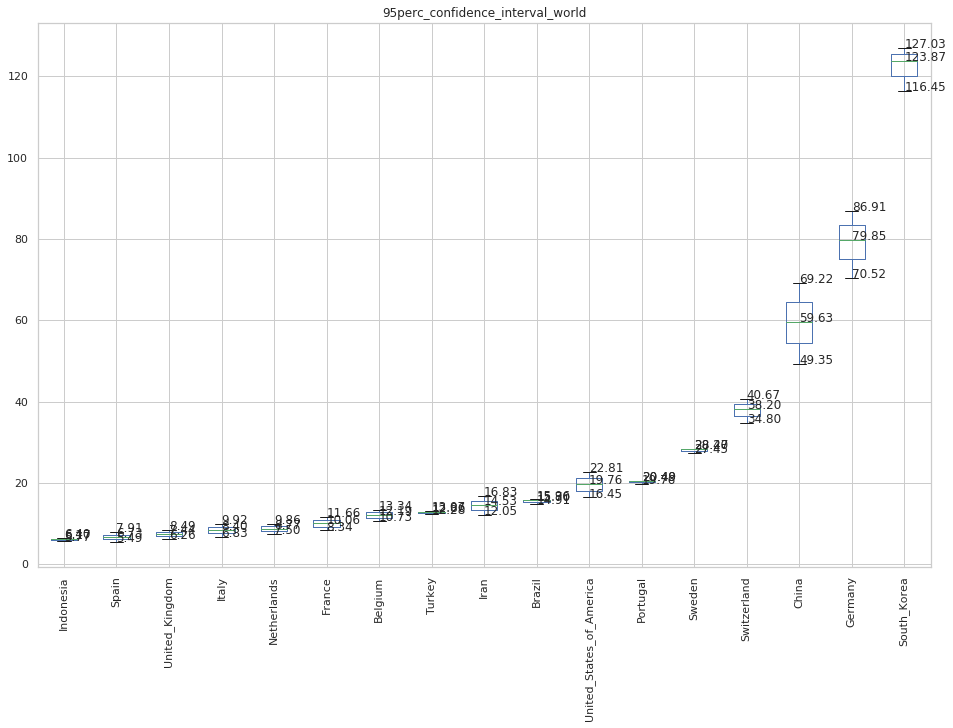

In [135]:
world_data['rel_date'] = (dt.datetime.now() - pd.to_datetime(world_data['date'])).dt.days - 1
world_data['known'] = HDT(world_data['rel_date'])
world_data['known_cases'] = world_data['known'] * world_data['cases']

wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').fillna(0).cumsum(axis = 1)
wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_cases = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
wd_reported = (2.6 / wd_death_rate * 100).replace(np.inf, np.nan)
wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
wd_reported.loc[['Germany', 'United_States_of_America', 'Italy','China']]

death_est = [2.0, 2.5, 3.0]

# print(wd_known_cases)
wd_curr = pd.DataFrame(wd_known_cases[str_today])
wd_curr['cases'] = wd_cases[str_today]
wd_curr['deaths'] = wd_deaths[str_today]
wd_curr.columns = ['known', 'cases', 'deaths']

def conf_int(count, nobs, alpha = 0.05, method = 'binom_test'):
    try:
        a = proportion.proportion_confint(count = count, nobs = nobs, alpha = alpha, method = method)
    except ValueError:
        a = [0, 0]
    return a

wd_curr['quantile25'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[0] for i in wd_curr.index]
wd_curr['quantile75'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[1] for i in wd_curr.index]
wd_curr['average'] = wd_curr['deaths'] / wd_curr['known']
wd_curr['quantile25_rep'] = (death_est[0] / wd_curr['quantile25']).replace(np.inf, np.nan)
wd_curr['quantile75_rep'] = (death_est[2] / wd_curr['quantile75']).replace(np.inf, np.nan)
wd_curr['average_rep'] = (death_est[1] / wd_curr['average']).replace(np.inf, np.nan)
wd_curr = wd_curr[wd_curr['deaths'] >= 100].sort_values(by='average_rep')

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
    
wd_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10), rot = 90)
df = wd_curr


plt.title('95perc_confidence_interval_world')
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
    plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
    plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)

In [136]:
    
# temp = world_data[['cases','country']]
# temp.columns = ['cases_14d', 'country']
# temp['date'] = world_data['date'] + dt.timedelta(days=13)
# temp = temp[temp['date'] <= str_today]
# world_data_adj = world_data.merge(temp, on = ['country', 'date'])

# world_data_adj['death_rate_14d'] = world_data_adj['deaths'] / world_data_adj['cases_14d']
# world_data_adj = world_data_adj[world_data_adj['date'] > '2020-03-22']

# pt_world_cases = world_data_adj.pivot_table(values = 'cases_14d', index = 'country', columns = 'date', aggfunc='mean')
# pt_world_cases = pt_world_cases.cumsum(axis = 1)
# pt_world_cases = pt_world_cases[pt_world_cases['2020-03-26'] > 100].sort_values(by='2020-03-26', ascending = False)

# pt_world_deaths = world_data_adj.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc='mean')
# pt_world_deaths = pt_world_deaths.cumsum(axis = 1)
# pt_world_deaths = pt_world_deaths[pt_world_deaths['2020-03-26'] > 0].sort_values(by='2020-03-26', ascending = False)

# df = pt_world_deaths / pt_world_cases * 100
# df = df.sort_values(by='2020-03-26', ascending = False).dropna()


# plt.figure(figsize = (20,10))

# plt.rc('font', **font)
# title = 'Death_rate_14d'
# plt.title(title)
# for i in df.T.iteritems():
#     temp = i[1].dropna()
#     plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
#     plt.legend()
    
# plt.savefig('./img/' + title)

In [137]:
us_daily_url = 'https://covidtracking.com/api/us/daily.csv'
us_covid = pd.read_csv(us_daily_url)
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
us_covid = us_covid.set_index('date', drop = True)
us_covid = us_covid.sort_values(by = 'date', ascending = True)
us_covid['new_cases'] = us_covid['positive'].diff().fillna(0)
us_data = us_covid.copy()

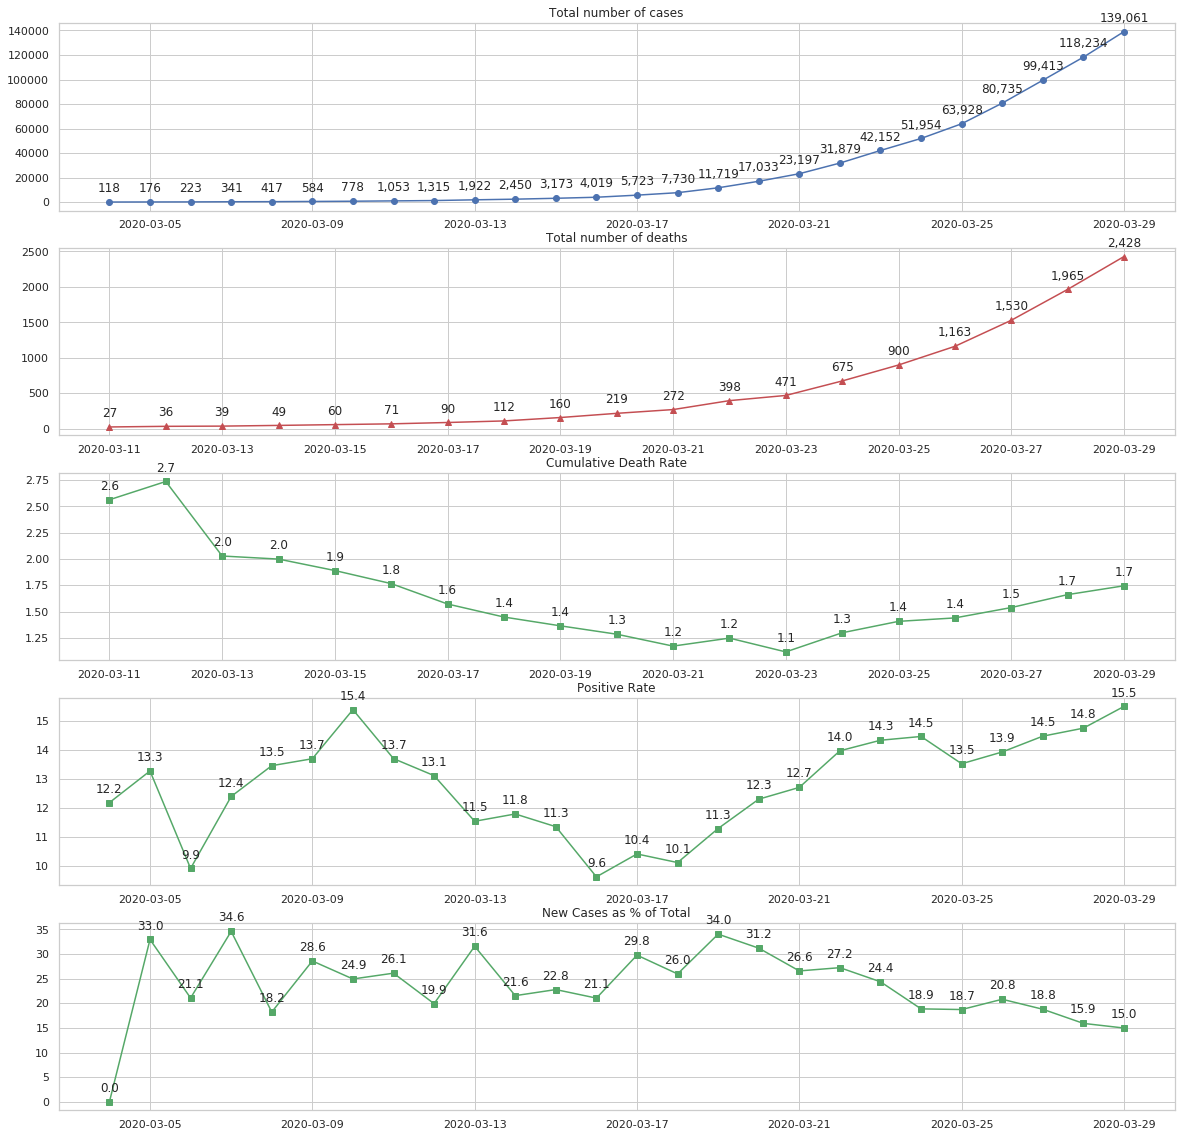

In [138]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = us_data.index.values
ys = us_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = us_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['death'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = us_data['positive'] / us_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = us_data['new_cases'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/us_overview')
plt.show()

In [139]:
states_daily_url = 'http://covidtracking.com/api/states/daily.csv'
us_covid_state = pd.read_csv(states_daily_url)
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
# us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_covid = ny_covid.sort_values(by='date')
ny_covid['new_cases'] = ny_covid['positive'].diff().fillna(0)
ny_data = ny_covid.copy()
# ny_data

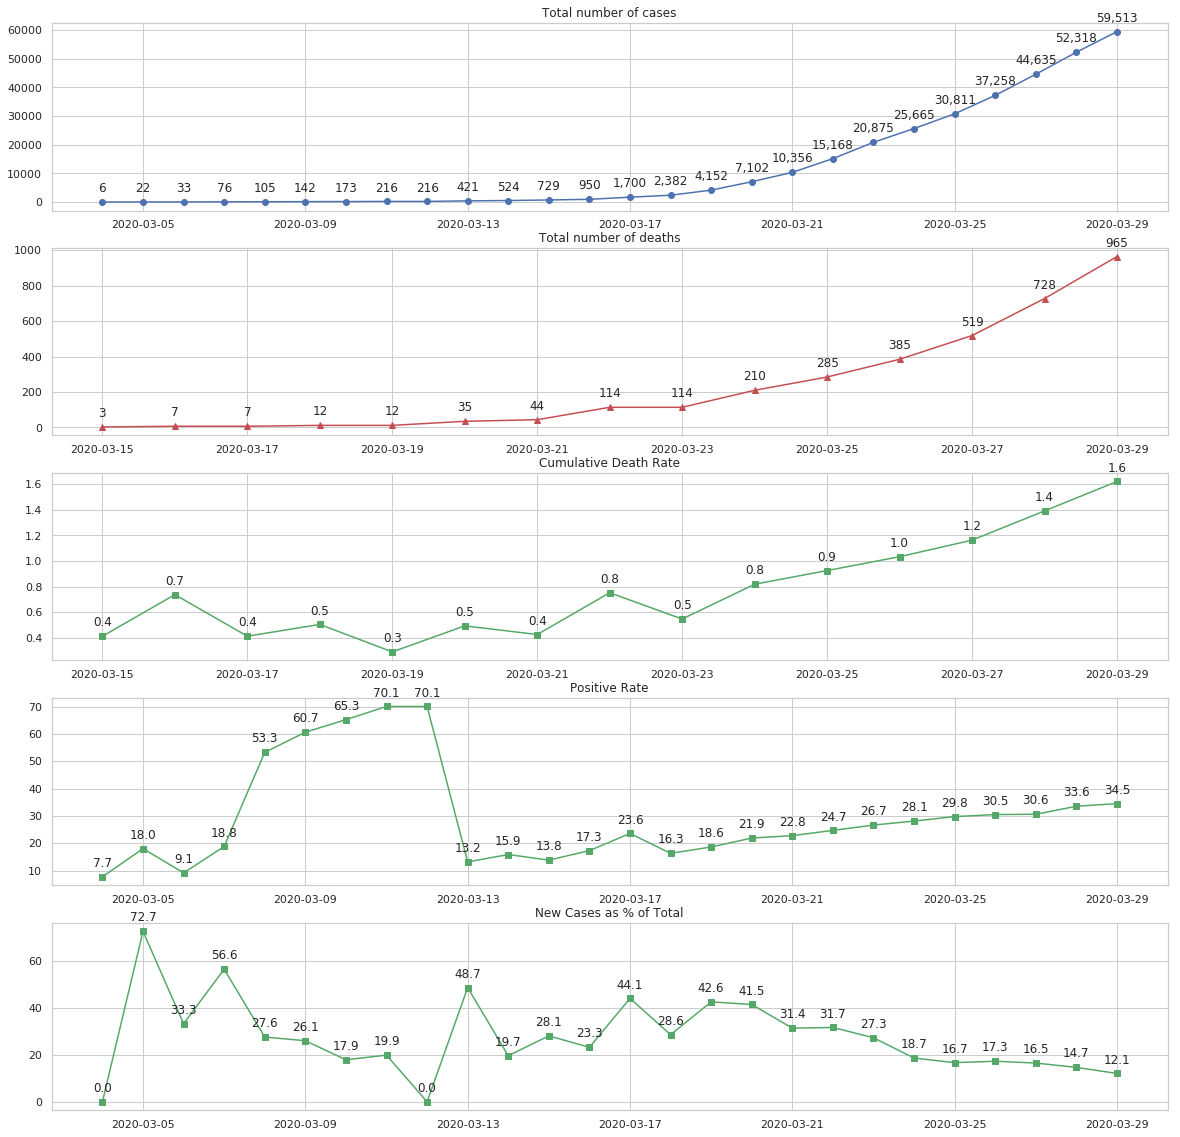

In [140]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = ny_data['date']
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

In [141]:
us_covid_state['rel_date'] = (dt.datetime.now() - pd.to_datetime(us_covid_state['date'])).dt.days - 1
us_covid_state = us_covid_state.set_index('date', drop = True)
us_covid_state['known'] = HDT(us_covid_state['rel_date'])
us_covid_state['known_cases'] = us_covid_state['known'] * us_covid_state['positive']
# us_covid_state

In [142]:
us_known_cases = us_covid_state.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).cumsum(axis = 1)
us_deaths = us_covid_state.pivot_table(values = 'death', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
us_deaths = us_deaths[us_deaths[str_today] > 10]
us_death_rate = (us_deaths / us_known_cases * 100).fillna(0)
us_death_rate = us_death_rate[us_death_rate[str_today] > 0]

In [143]:
us_reported = (3.2 / us_death_rate * 100).replace(np.inf, np.nan)
us_reported = us_reported[us_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
us_reported

date,2020-03-26,2020-03-27,2020-03-28,2020-03-29
state,,,,
NC,660.835172,332.235307,199.341184,142.386560
UT,306.043765,219.582850,170.786661,139.734541
TN,341.637392,214.598101,156.071346,118.398952
AL,1140.267967,287.164637,164.094078,104.423504
IA,425.273538,170.781233,106.738271,71.158847
MN,234.899587,149.998738,103.124133,65.999445
AR,225.171699,141.413064,87.023424,59.542343
MD,97.521355,79.192770,66.419743,50.219805
DE,498.316480,166.882134,83.441067,41.720534


In [144]:
us_state = us_covid_state[us_covid_state.index == str_today].set_index('state', drop = True)
us_state['positive_rate'] = us_state['positive'] / us_state['total'] * 100
us_state['death_rate'] = us_state['death'] / us_state['positive'] * 100
us_state = us_state.fillna(0)

us_state_data = pd.read_csv('us_states_data.csv')
us_state_data.columns = ['state', 'population','area-miles', 'area']
us_state_data['population'] = us_state_data['population'].str.replace(',','').astype(int)
us_state_data['area-miles'] = us_state_data['area-miles'].str.replace(',','').astype(int)
us_state_data['area'] = us_state_data['area'].str.replace(',','').astype(int)
us_state_data['density'] = us_state_data['population'].astype(float) / us_state_data['area'].astype(float)
us_state_data = us_state_data.set_index('state', drop = True)

us_state = us_state.merge(us_state_data, on='state')
us_state['tests_per_1000'] = us_state['total'] / us_state['population'] * 1000
us_state['positive_per_1000'] = us_state['positive'] / us_state['population'] * 1000

In [145]:
# us_state.sort_values(by='positive_rate', ascending=False)
df_corr = us_state[['tests_per_1000','positive_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()

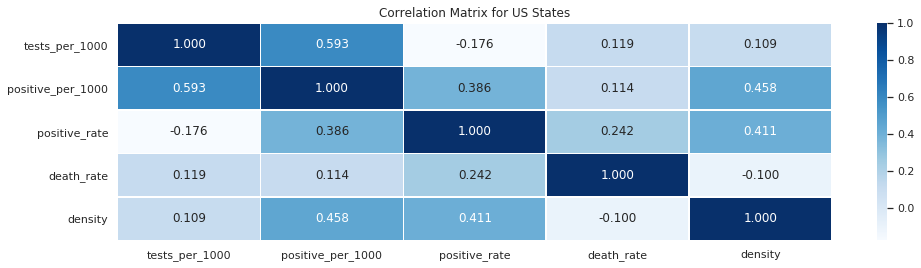

In [146]:
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for US States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)

In [147]:
br_state_file = './'
kaggle.api.authenticate()
kaggle.api.dataset_download_files('unanimad/corona-virus-brazil/metadata', path=br_state_file, unzip=True)

br_state = pd.read_csv('brazil_covid19.csv')
br_state['total'] = br_state['cases'] + br_state['refuses']
br_state['total_susp'] = br_state['cases'] +  br_state['refuses'] + br_state['suspects']
br_state['positive_rate'] = br_state['cases'] / br_state['total'] * 100
br_state_copy = br_state.copy()
br_state = br_state[br_state['date'] == str_today]
br_state = br_state.set_index('state', drop=True)
br_state['death_rate'] = br_state['deaths'] / br_state['cases'] * 100
br_state_data = pd.read_csv('br_states_data.csv')
br_state_data = br_state_data.drop(['Bandeira', 'Sede de governo','Alfabetização (2016)', 'Mortalidade infantil (2016)', 'Expectativa de vida (2016)'], axis = 1)
br_state_data.columns = ['state', 'state_2digits', 'area', 'population', 'density', 'gdp', 'share','gdp_per_capita', 'hdi']
br_state_data = br_state_data.set_index('state', drop=True)
br_state_data = br_state.merge(br_state_data, on='state')
br_state_data['area'] = br_state_data['area'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['population'] = br_state_data['population'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['gdp'] = br_state_data['gdp'].str.replace(',','').str.replace('\xa0','').astype(float)
br_state_data['gdp_per_capita'] = br_state_data['gdp_per_capita'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['hdi'] = br_state_data['hdi'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['density'] = br_state_data['density'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['tests_per_1000'] = br_state_data['total'] / br_state_data['population'] * 1000
# br_state_data = br_state_data.set_index('state_2digits', drop = True)
br_state

,date,hour,suspects,refuses,cases,deaths,total,total_susp,positive_rate,death_rate
state,,,,,,,,,,
Acre,2020-03-29,NaN,0,0,34,0,34,34,100.0,0.000000
Alagoas,2020-03-29,NaN,0,0,17,0,17,17,100.0,0.000000
Amapá,2020-03-29,NaN,0,0,4,0,4,4,100.0,0.000000
Amazonas,2020-03-29,NaN,0,0,140,1,140,140,100.0,0.714286
Bahia,2020-03-29,NaN,0,0,154,1,154,154,100.0,0.649351
Ceará,2020-03-29,NaN,0,0,348,5,348,348,100.0,1.436782
Distrito Federal,2020-03-29,NaN,0,0,289,1,289,289,100.0,0.346021
Espírito Santo,2020-03-29,NaN,0,0,60,0,60,60,100.0,0.000000
Goiás,2020-03-29,NaN,0,0,58,1,58,58,100.0,1.724138


In [148]:
br_date = br_state_copy.groupby('date').sum()
br_date['death_rate'] = (br_date['deaths'] / br_date['cases']).fillna(0)
br_date['new_cases'] = br_date['cases'].diff().fillna(0)
br_date = br_date[br_date.index > '2020-02-20']

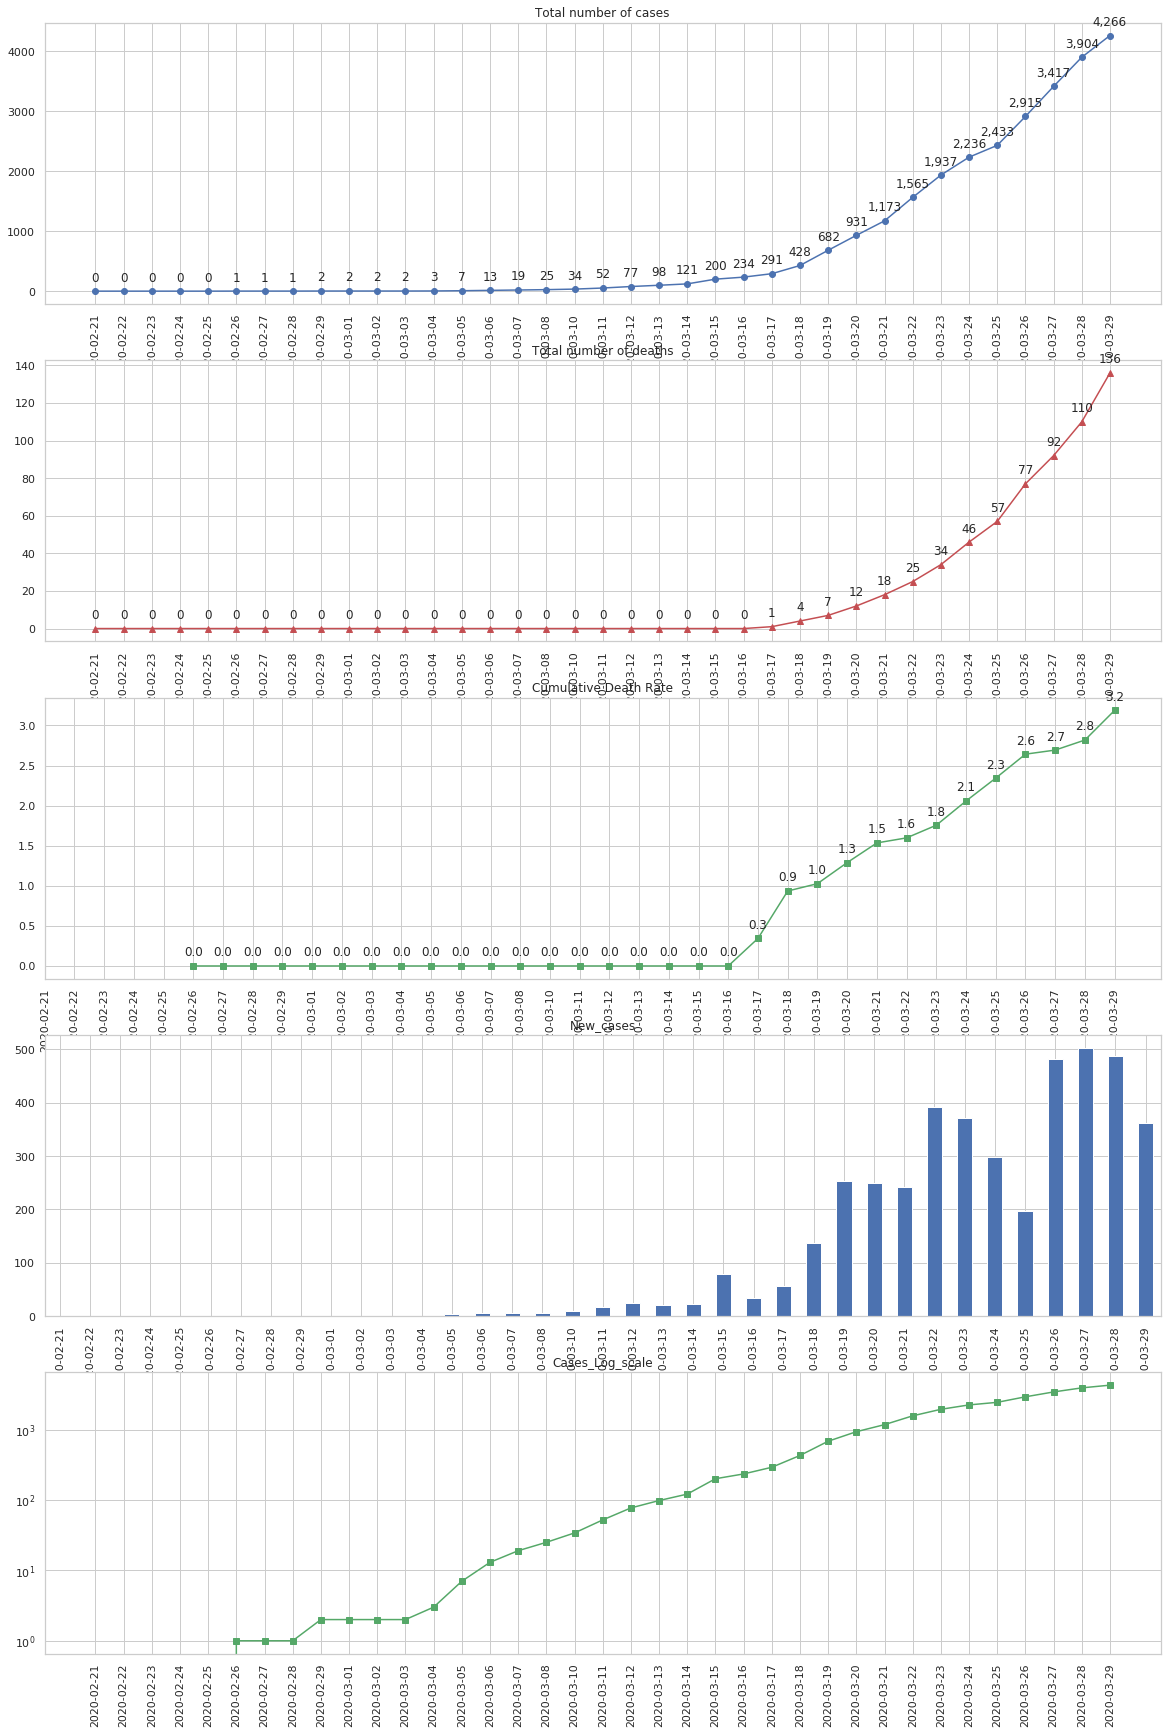

In [149]:
plt.figure(figsize = (20,30))

plt.subplot('511')
xs = br_date.index.values
ys = br_date['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = br_date['deaths']
plt.plot(xs, ys, 'r^-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = br_date['deaths'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('New_cases')
ys = br_date['new_cases']
# plt.plot(x = xs, y = ys)
br_date['new_cases'].plot(kind = 'bar')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

# plt.savefig('./img/br_overview')

plt.subplot('515')
plt.gca().set_title('Cases_Log_scale')
ys =  br_date['cases']
plt.plot(xs, ys, 'gs-')
plt.yscale('log')
plt.xticks(xs, xs, rotation='vertical')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/br_overview')
plt.show()

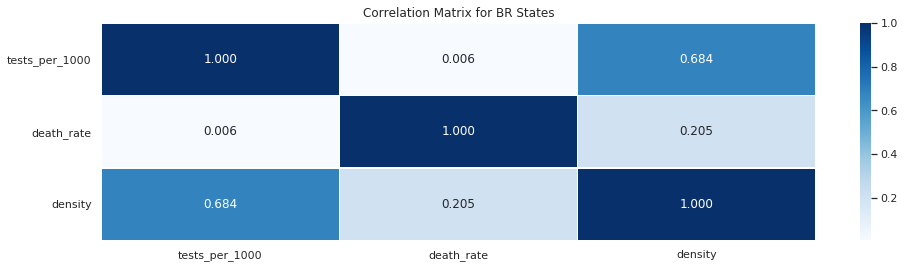

In [150]:
df_corr = br_state_data[['tests_per_1000','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for BR States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)

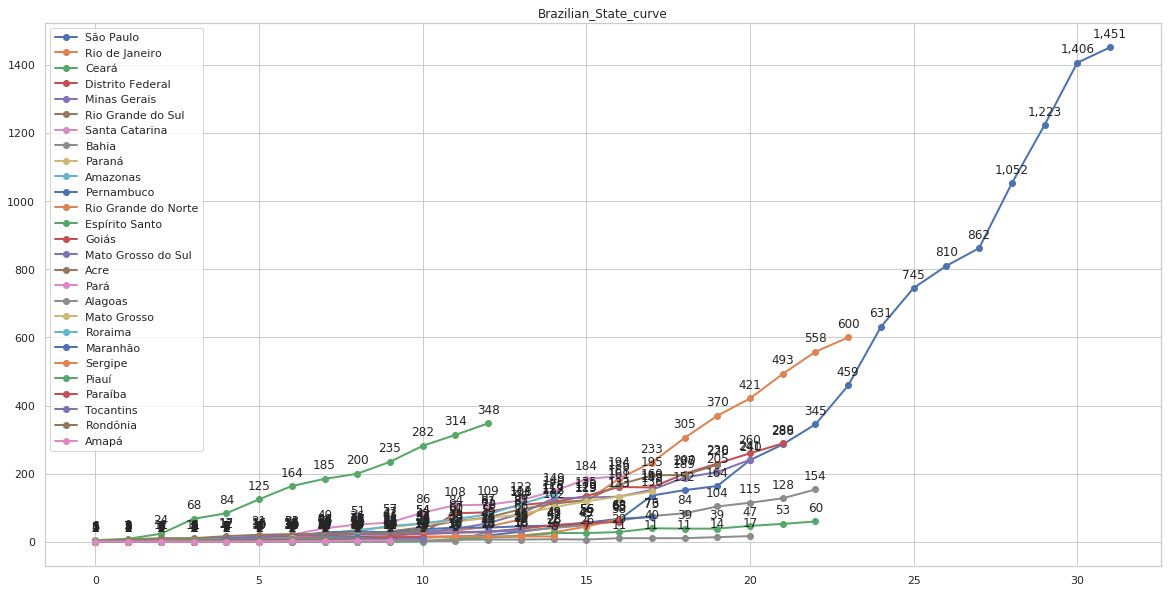

In [151]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

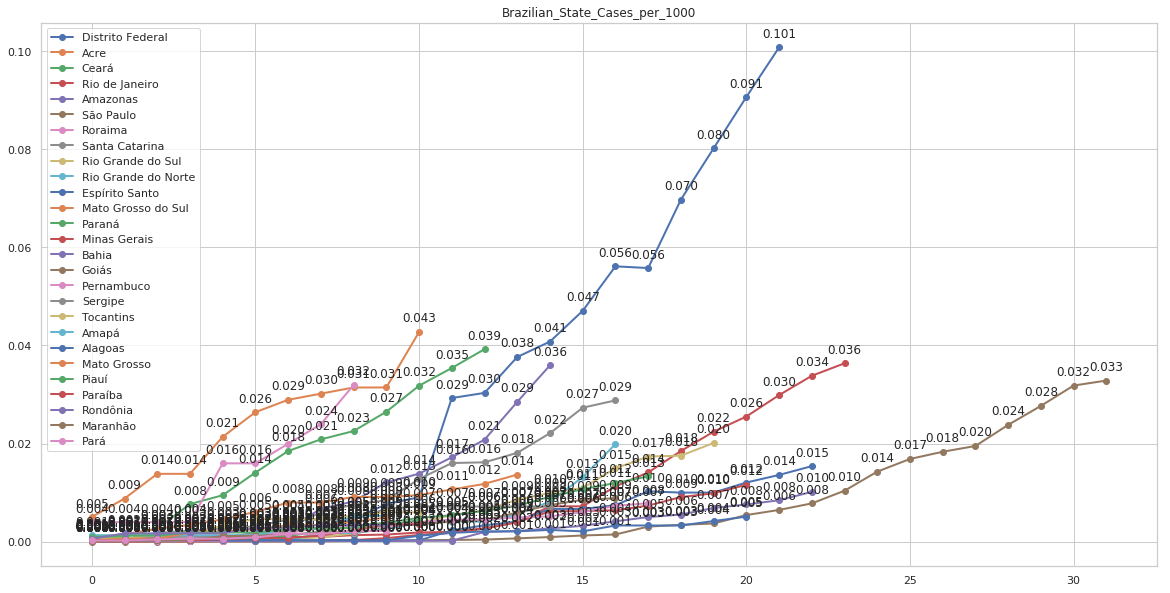

In [152]:
pt_br_state_adj =  pt_br_state.div(br_state_data['population'], axis = 0) * 1000
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_per_1000'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.3f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

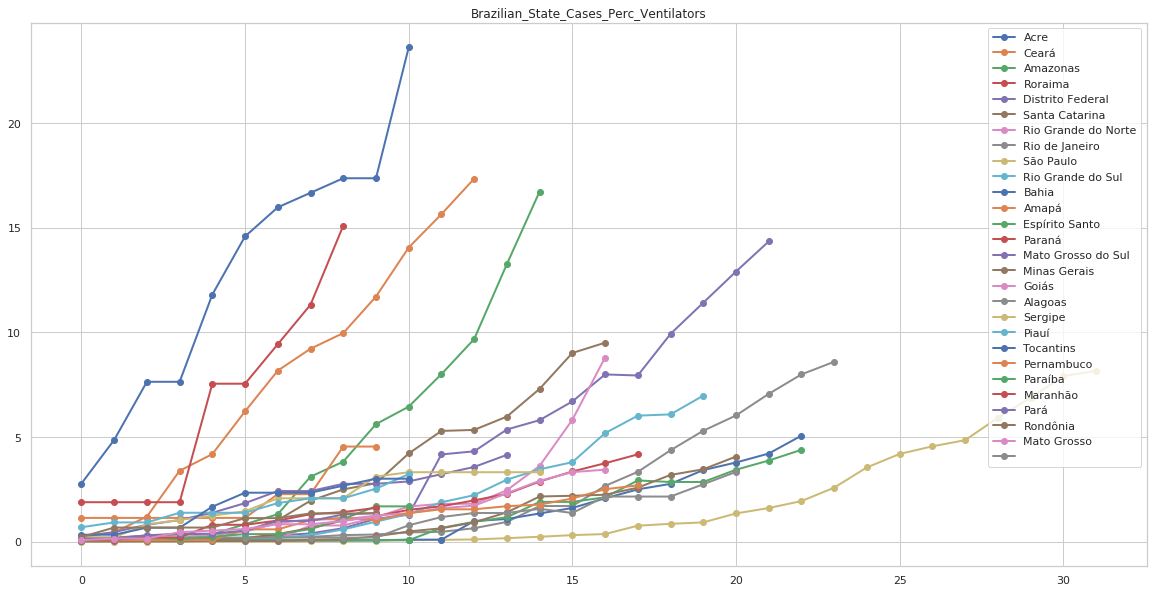

In [153]:
pt_br_state_adj =  pt_br_state.div(resp['equipments'], axis = 0) * 100
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Perc_Ventilators'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

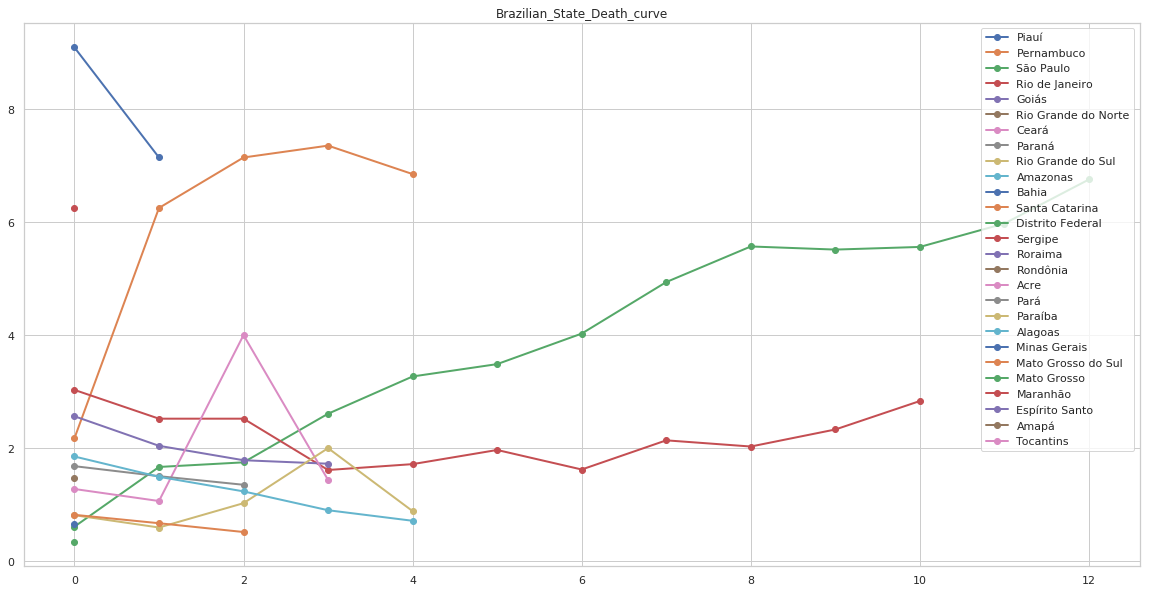

In [154]:
pt_br_state_death  = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum') / pt_br_state * 100
pt_br_state_death.loc['Ceará']['2020-03-28'] = 4
pt_br_state_death.loc['Rio Grande do Sul']['2020-03-28'] = 2
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Death_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

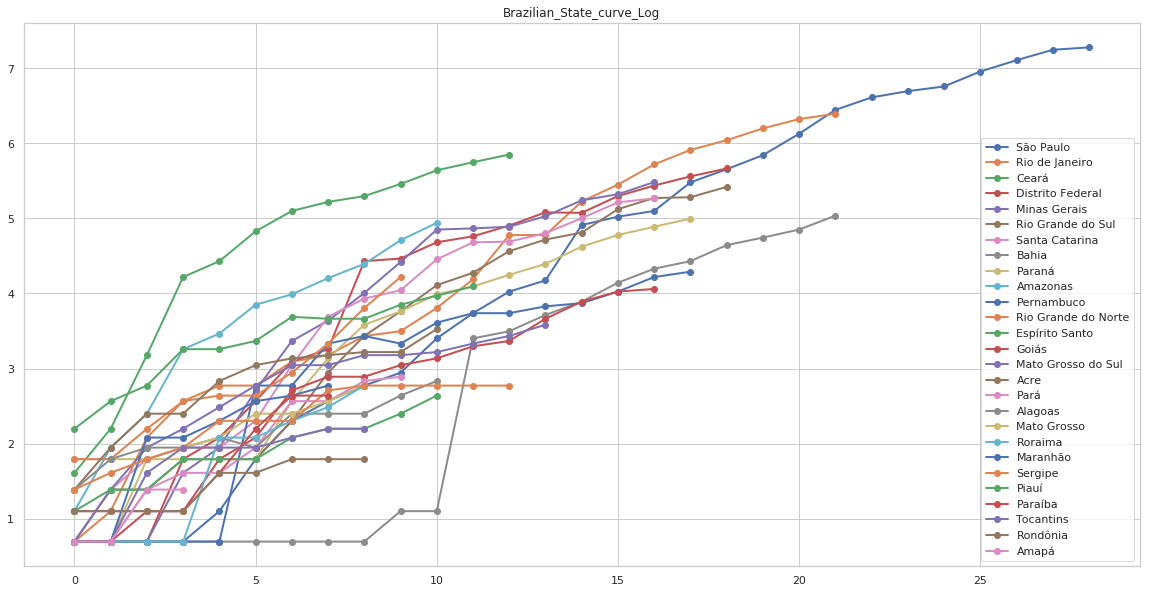

In [155]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1].apply(np.log)
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

In [156]:
br_cases = pd.DataFrame(br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).diff(axis = 1).fillna(0).unstack())
br_cases.columns = ['cases']
br_cases = br_cases.reset_index()

In [174]:
br_cases['rel_date'] = (dt.datetime.now() - pd.to_datetime(br_cases['date'])).dt.days
br_cases['known'] = HDT(br_cases['rel_date'])
br_cases['known_cases'] = br_cases['known'] * br_cases['cases']

br_total_cases = br_cases.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
br_total_cases.loc['Brasil'] = br_total_cases.sum()
total_cases = br_total_cases.loc['Brasil']
br_total_cases

br_known_cases = br_cases.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
df = br_known_cases.sort_values(by=str_today, ascending = False)
br_known_cases.loc['Brasil'] = br_known_cases.sum()
# br_known_cases

In [175]:
br_deaths = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0)
br_deaths.loc['Ceará']['2020-03-28'] = 4
br_deaths.loc['Rio Grande do Sul']['2020-03-28'] = 2
br_deaths.loc['Brasil'] = br_deaths.sum()
# br_deaths

In [176]:
a = 114 / (899 / 0.102) 
b = (1090 / 0.110)
print(a)
print(a * b)
print(a * b / 0.029)

0.012934371523915461
128.16786328243504
4419.581492497759


In [177]:
a = 114 / (899 / 0.102) 
b = (1090 / 0.10)
print(a)
print(a * b)
print(a * b / 0.029)

0.012934371523915461
140.98464961067853
4861.539641747535


In [178]:
br_death_rate = (br_deaths / br_known_cases * 100).fillna(0)

In [179]:
br_death_rate = br_death_rate[br_death_rate[str_today] > 0]
# br_death_rate

In [180]:
death_est = [1.2, 1.3, 1.4]

br_reported = (death_est[1] / br_death_rate * 100).replace(np.inf, np.nan)
known_cases = br_known_cases.loc['Brasil']
br_reported = br_reported[br_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
br_reported

date,2020-03-26,2020-03-27,2020-03-28,2020-03-29
state,,,,
Distrito Federal,NaN,NaN,NaN,103.479283
Santa Catarina,58.403036,59.681192,NaN,59.884435
Bahia,NaN,NaN,NaN,47.060082
Rio Grande do Sul,70.581375,35.929765,35.935572,35.935572
Amazonas,24.737209,25.399956,25.574165,25.574165
Paraná,NaN,23.745641,23.786289,23.786289
Ceará,35.055615,35.797262,26.894402,21.515521
Goiás,18.966754,19.440145,19.480793,19.480793
Rio de Janeiro,20.502643,18.793220,14.485358,11.077038


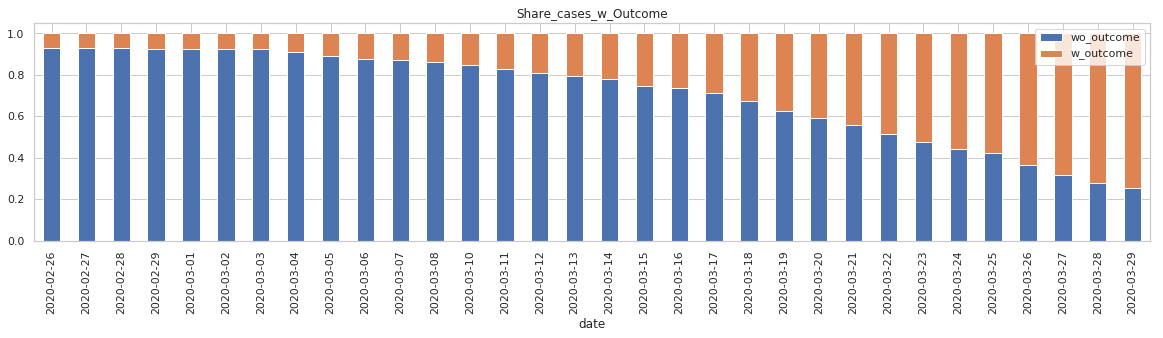

In [192]:
tps = pd.DataFrame([known_cases, total_cases - known_cases], index = ['wo_outcome', 'w_outcome']).T
tps = tps[tps['w_outcome'] > 0]
tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True, figsize = (20,4))
plt.title('Share_cases_w_Outcome')
plt.savefig('./img/' + title)

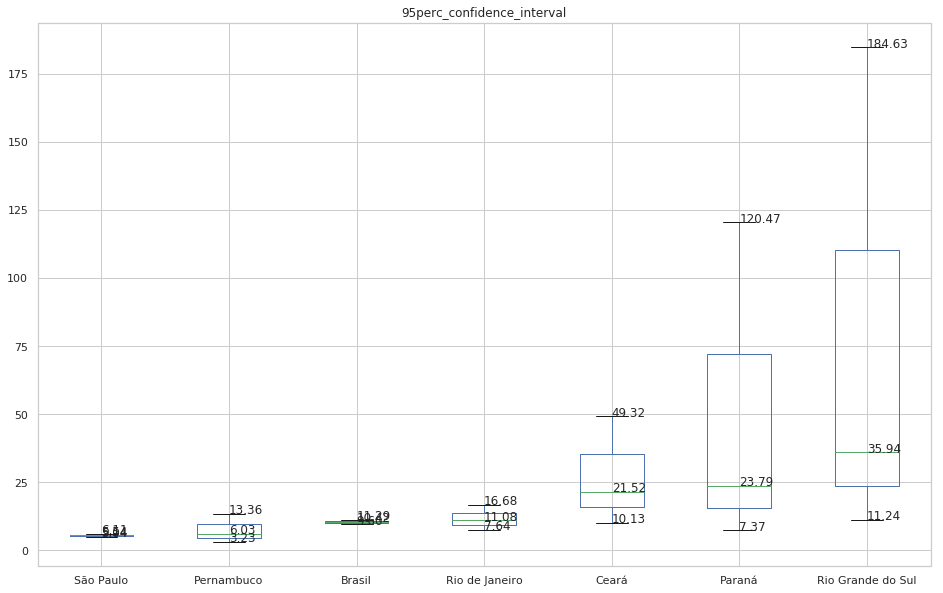

In [167]:
br_curr = br_known_cases[[str_today]]
br_curr['cases'] = pt_br_state[str_today]
br_curr['deaths'] = br_deaths[str_today]
br_curr.columns = ['known', 'cases', 'deaths']

def conf_int(count, nobs, alpha = 0.05, method = 'binom_test'):
    try:
        a = proportion.proportion_confint(count = count, nobs = nobs, alpha = alpha, method = method)
    except ValueError:
        a = [0, 0]
    return a

br_curr['quantile25'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[0] for i in br_curr.index]
br_curr['quantile75'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[1] for i in br_curr.index]
br_curr['average'] = br_curr['deaths'] / br_curr['known']
br_curr['quantile25_rep'] = (death_est[0] / br_curr['quantile25']).replace(np.inf, np.nan)
br_curr['quantile75_rep'] = (death_est[2] / br_curr['quantile75']).replace(np.inf, np.nan)
br_curr['average_rep'] = (death_est[1] / br_curr['average']).replace(np.inf, np.nan)
br_curr = br_curr[br_curr['deaths'] >= 2].sort_values(by='average_rep')

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
    
br_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10))
df = br_curr


plt.title('95perc_confidence_interval')
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
    plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
    plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)

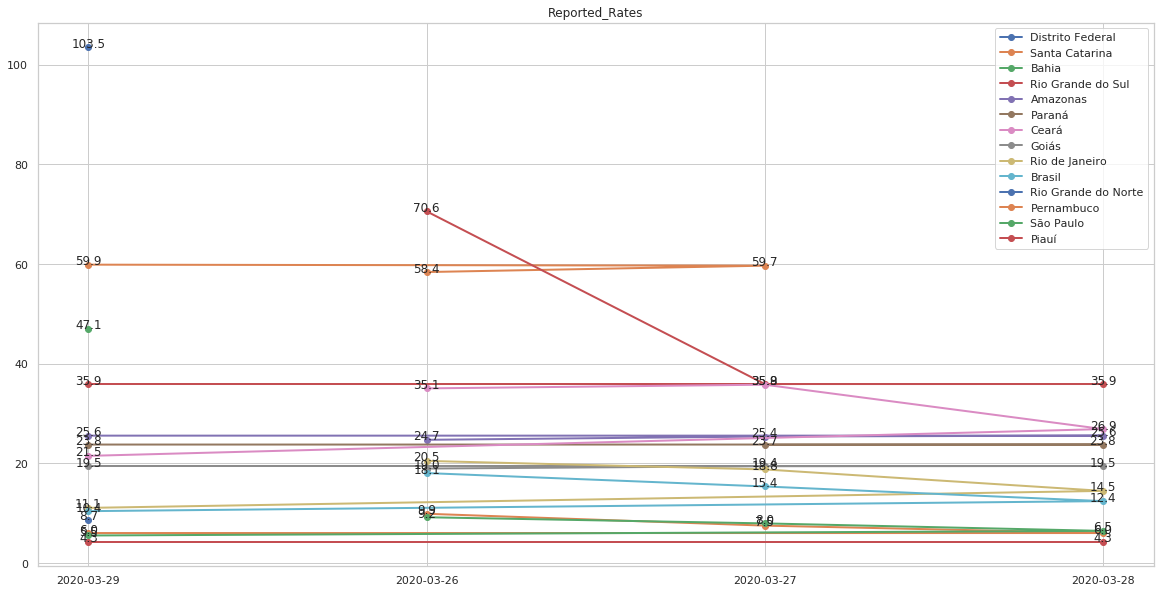

In [164]:
df = br_reported

plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Reported_Rates'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.1f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)